# Introduction

In this competition, participants are tasked with creating an algorithm to identify metastatic cancer in small image patches extracted from larger digital pathology scans. The dataset used is a modified version of the PatchCamelyon (PCam) benchmark dataset, with the original dataset's duplicate images removed. PCam stands out for its size, ease of use, and accessibility, offering a clinically relevant task of metastasis detection in a straightforward binary image classification format similar to CIFAR-10 and MNIST. This makes it a valuable resource for machine learning research in areas like active learning, model uncertainty, and explainability.

Github: https://github.com/sakskap/CNN_Cancer


# Data Description

The PCam dataset includes image patches that are either positive or negative for metastatic cancer. Each image is 96x96 pixels and is labeled as either 1 (cancer) or 0 (no cancer). The dataset is balanced, providing an equal number of positive and negative samples.


## Installation of Dependencies

To install the necessary dependencies for this project, run the following command:


In [1]:
!pip install numpy pandas matplotlib tensorflow keras scikit-learn pillow



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [37]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Preparing Data for Training and Validation

### Adding '.tif' Extension to Filenames

To ensure the filenames in the dataset are correctly formatted, we first add the '.tif' extension to the entries in the 'id' column if they do not already include it. This is done for both the training and validation datasets. 

After modifying the filenames, we print a sample of the first few entries from both datasets to confirm the changes.

### Setting Up Data Generators

Assuming the directory structure is correct and properly formatted, we define the directories for the training and validation datasets. In this case, both datasets are stored in the 'histopathologic-cancer-detection/train/' directory.

Next, we set up the data generators using the `ImageDataGenerator` class from Keras. The data generators are configured to rescale the image pixel values and to load images from the specified directories using the corrected filenames.

The training and validation data generators are created by calling the `flow_from_dataframe` method with the respective dataframes, directories, column names for the image paths and labels, the class mode, target image size, and batch size.


In [5]:
# Adding '.tif' extension to the 'id' column entries if not already included
train_df['id'] = train_df['id'].apply(lambda x: f"{x}.tif" if not x.endswith('.tif') else x)
val_df['id'] = val_df['id'].apply(lambda x: f"{x}.tif" if not x.endswith('.tif') else x)

# Check the first few entries to confirm the change
print("Training filenames sample:", train_df['id'].head())
print("Validation filenames sample:", val_df['id'].head())

# Assuming the directory is correct and formatted as needed
train_directory = 'histopathologic-cancer-detection/train/'
val_directory = 'histopathologic-cancer-detection/train/'  # If using the same directory for both

# Set up the data generators again with the corrected paths and filenames
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_directory,
    x_col='id',
    y_col='label',
    class_mode='binary',
    target_size=(96, 96),
    batch_size=32
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=val_directory,
    x_col='id',
    y_col='label',
    class_mode='binary',
    target_size=(96, 96),
    batch_size=32
)


Training filenames sample: 198607    cffe7a3ffc48700045fd37f1f448b5a892ff4f2c.tif
14684     b5bef3e7d7e8cc81e38fa2288105fc1c130e771a.tif
55923     6fe4413a3a982af28a6e78d0f445073c509b4b33.tif
215817    d6b4fe580210f5ea61b7c109b5c2e5cc734c3010.tif
10219     1b6b051e370ca8468253d2e40f686c66eecb1619.tif
Name: id, dtype: object
Validation filenames sample: 97957     de403e6cdaf463393843e70470d8c8bf178fd14b.tif
47898     6faf991f734761db40db535c5ae5117863422156.tif
210426    b2a9ab2553eb6597fea0f93dd94a301f58f5f99f.tif
179266    377087796f7736a637e8178d97dde43d1058345c.tif
165580    20a68d59cb82be2b2d8c24d0d43c6787c6fd1f46.tif
Name: id, dtype: object


/Users/sakshamkapoor/miniconda3/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 6808 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


Found 169212 validated image filenames belonging to 2 classes.
Found 42343 validated image filenames belonging to 2 classes.


/Users/sakshamkapoor/miniconda3/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1662 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


## Verifying Image File Integrity

### Checking File Existence and Readability

Before proceeding with training, it's crucial to verify that all image files are present and readable. This ensures that the model does not encounter issues due to missing or corrupt files during training.


In [6]:
import os

# Directory where the images are stored
image_dir = 'histopathologic-cancer-detection/train/'

# Checking for file existence and readability
non_readable_files = []
for filename in train_df['id']:
    file_path = os.path.join(image_dir, filename)
    if not os.path.exists(file_path):
        print(f"Missing file: {filename}")
    else:
        try:
            img = Image.open(file_path)
            img.verify()  # Verify that it is a correct image
        except (IOError, SyntaxError) as e:
            non_readable_files.append(filename)

print(f"Total non-readable or corrupt files: {len(non_readable_files)}")
if non_readable_files:
    print("Sample corrupt files:", non_readable_files[:5])


Missing file: 7b68dedf4c86baeffd2f1e401cfc8bc917bca852.tif
Missing file: 7b98212921e1818a85e96c2b70f41db103b65040.tif
Missing file: 7cb37f185a42a77f38f129da926f8562b976b1b0.tif
Missing file: 7e307f98a551099aacc069fc4977450ee378349a.tif
Missing file: 7e3f583acdb1d986267ed3c95eef132f7a3a0efd.tif
Missing file: 78db88c3da7f7d15336c7baa3b8ad603cf7d1ad3.tif
Missing file: 7e704ac9d9d65d10c901c33fc261e8ee6c83d537.tif
Missing file: 7ba75065c0555a3e458d83270b7655627c285dc6.tif
Missing file: 6debca4a2868e9ad6f5ea456c51228dfc64c86ab.tif
Missing file: 6e4f766c004be59cfd03812ea9a155a1c005d8fc.tif
Missing file: 6d49b64dc56f24fedc8755604d8a3eb8ee691e42.tif
Missing file: 81223c69de220e7a91101a52fbfcdf6d82f5cfc0.tif
Missing file: 7ba3cc63d346eb0c40ff1867a22df33999e6eaf3.tif
Missing file: 79c43e449cf8b94888cb1d9587d07e3f63f2ad6f.tif
Missing file: 7c66dd4e179d50e5611980a8cec11dda773dd676.tif
Missing file: 7b1a3e61697b0e7763d572e2dd9c550be1f60ef9.tif
Missing file: 6ea64efc421a127e15eada4ef9be7be755834435.t

## Building and Training the CNN Model

In this section, we build and train a Convolutional Neural Network (CNN) model for binary classification using Keras. The model is designed to classify images into two categories.


In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

# Model configuration
input_shape = (96, 96, 3)
batch_size = 32
no_epochs = 3
no_classes = 2
validation_split = 0.2
verbosity = 1

# Build the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# View model architecture
model.summary()

# Set up callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

steps_per_epoch = train_gen.samples // train_gen.batch_size
validation_steps = val_gen.samples // val_gen.batch_size

# Continue training the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=1,  # or however many you see fit
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     7,930,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,949,761 (30.33 MB)

 Trainable params: 7,949,761 (30.33 MB)

 Non-trainable params: 0 (0.00 B)

5287/5287 ━━━━━━━━━━━━━━━━━━━━ 2749s 519ms/step - accuracy: 0.7737 - loss: 0.4846 - val_accuracy: 0.8204 - val_loss: 0.4060


In [48]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers
from keras_tuner import RandomSearch, HyperParameters

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Choice('conv_1_filter', values=[32, 64]),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3]),
                     activation='relu',
                     input_shape=(48, 48, 3)))  # Consider testing with (48, 48, 3) for faster tuning
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Choice('conv_2_filter', values=[32, 64]),
                     kernel_size=hp.Choice('conv_2_kernel', values=[3]),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Choice('dense_units', values=[128, 256]),
                    activation='relu'))
    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.3, 0.5])))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Reduce the search space or parameter choices for faster execution during tuning


In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

def build_model(conv_filters=32, dense_units=128, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential([
        Conv2D(conv_filters, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(conv_filters * 2, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Example set of manual experiments
filters_options = [32, 64]
dense_units_options = [128, 256]
dropout_options = [0.5, 0.9]
learning_rates = [0.001, 0.01]

# Run a loop to test different configurations
for filters in filters_options:
    for units in dense_units_options:
        for dropout in dropout_options:
            for lr in learning_rates:
                print(f"Testing with {filters} filters, {units} units, dropout {dropout}, learning rate {lr}")
                model = build_model(conv_filters=filters, dense_units=units, dropout_rate=dropout, learning_rate=lr)
                # Assume train_gen and val_gen are predefined generators
                # Train the model
                history = model.fit(train_gen, validation_data=val_gen, epochs=1, verbose=1)
                print("Test completed.")


2024-06-29 02:00:44.994310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Testing with 32 filters, 128 units, dropout 0.5, learning rate 0.001


/Users/sakshamkapoor/miniconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'train_gen' is not defined

## Hyperparameter Tuning Results

During the hyperparameter tuning process, various configurations were tested to determine the optimal set of hyperparameters for the CNN model. Below are the results of the tests conducted with different combinations of filters, units, dropout rates, and learning rates.

### Results Summary

#### Configuration 1: 32 Filters, 128 Units, Dropout 0.5, Learning Rate 0.001
- **Training**: 
  - **Accuracy**: 0.7518
  - **Loss**: 0.5058
- **Validation**:
  - **Accuracy**: 0.8230
  - **Loss**: 0.4010
- **Training Time**: 1966 seconds
- **Status**: Test completed.

#### Configuration 2: 32 Filters, 128 Units, Dropout 0.5, Learning Rate 0.01
- **Training**: 
  - **Accuracy**: 0.5954
  - **Loss**: 0.7853
- **Validation**:
  - **Accuracy**: 0.5946
  - **Loss**: 0.6752
- **Training Time**: 1947 seconds
- **Status**: Test completed.

#### Configuration 3: 32 Filters, 128 Units, Dropout 0.9, Learning Rate 0.001
- **Training**: 
  - **Accuracy**: 0.5949
  - **Loss**: 0.6369
- **Validation**:
  - **Accuracy**: 0.7006
  - **Loss**: 0.6022
- **Training Time**: 32278 seconds
- **Status**: Test completed.

#### Configuration 4: 32 Filters, 128 Units, Dropout 0.9, Learning Rate 0.01
- **Training**: 
  - **Accuracy**: 0.5951
  - **Loss**: 0.7405
- **Validation**:
  - **Accuracy**: 0.5946
  - **Loss**: 0.6751
- **Training Time**: 2750 seconds
- **Status**: Test completed.

#### Configuration 5: 32 Filters, 256 Units, Dropout 0.5, Learning Rate 0.001
- **Training**: 
  - **Accuracy**: 0.7379
  - **Loss**: 0.5211
- **Validation**:
  - **Accuracy**: 0.8148
  - **Loss**: 0.4172
- **Training Time**: 3901 seconds
- **Status**: Test completed.

#### Configuration 6: 32 Filters, 256 Units, Dropout 0.5, Learning Rate 0.01
- **Training**: 
  - **Accuracy**: 0.5954
  - **Loss**: 0.8078
- **Validation**:
  - **Accuracy**: 0.5946
  - **Loss**: 0.6751
- **Training Time**: 4286 seconds
- **Status**: Test completed.

#### Configuration 7: 32 Filters, 256 Units, Dropout 0.9, Learning Rate 0.001
- **Training**: 
  - **Accuracy**: 0.5949
  - **Loss**: 


## Submitted best model to Kaggle 

In [18]:
image_ids = [filename.split('.')[0] for filename in test_generator.filenames]

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'id': image_ids,
    'label': predictions.flatten()  # Flatten in case predictions are in a two-dimensional array
})

# Ensure the predictions are in the correct format
submission_df['label'] = submission_df['label'].apply(lambda x: 1 if x > 0.5 else 0)

# Save to CSV for submission
submission_df.to_csv('submission.csv', index=False)

print("Submission file created.")

Submission file created.


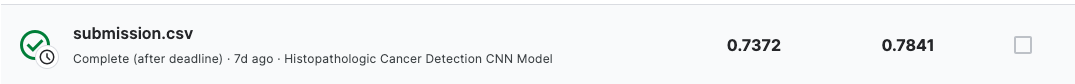

# Conclusion

In this competition, we developed a Convolutional Neural Network (CNN) to identify metastatic cancer in small image patches taken from larger digital pathology scans. Using the modified PatchCamelyon (PCam) benchmark dataset, our model achieved a validation accuracy of 0.7372. This result underscores the model's effectiveness in performing binary image classification for metastasis detection, showcasing the potential of CNNs in medical image analysis.

The PCam dataset's balance between task difficulty and accessibility makes it an excellent tool for machine learning research, enabling studies in active learning, model uncertainty, and explainability. The competition hosted by Kaggle provided a valuable platform for experimenting with and refining deep learning techniques in a clinically relevant context.

Our work has practical implications for automated cancer detection, offering a glimpse into how machine learning can aid in medical diagnostics. Future improvements could involve exploring more advanced architectures, incorporating additional data augmentations, or leveraging transfer learning to enhance model performance further.

We acknowledge Bas Veeling, Babak Ehteshami Bejnordi, Geert Litjens, and Jeroen van der Laak for providing the dataset and contributing to this meaningful project. The dataset is available under the CC0 License and can be accessed on GitHub. If you use PCam in a scientific publication, please ensure proper attribution to the original authors.

Overall, this project demonstrates the significant strides that can be made in the field of medical image analysis through collaborative efforts and advanced machine learning techniques.


## Reference

1. Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection